In [2]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt




# Network configuration variables
input_size = 1
num_gaussians = 50
num_sigmoids = 0
output_size = 1

In [3]:
def print_basis_function_sum(net):
    with torch.no_grad():
        sigma = torch.exp(net.log_sigmas).view(-1)
        mu = net.means.view(-1)
        amp_gauss = net.fc2.weight[0, :net.num_gaussians]

        scales = torch.exp(net.scales).view(-1)
        origins = net.origins.view(-1)
        amp_sigm = net.fc2.weight[0, net.num_gaussians:]

        bias = net.fc2.bias.item()

    print("Neural Network Output Function:")
    print("f(x) = ", end="")
    
    # Gaussian terms
    for i in range(net.num_gaussians):
        print(f"{amp_gauss[i].item():+.4f} * exp(-0.5 * ((x - {mu[i].item():.4f}) / {sigma[i].item():.4f})^2)", end=" ")

    # Sigmoid terms
    for i in range(net.num_sigmoids):
        print(f"{amp_sigm[i].item():+.4f} * sigmoid((x - {origins[i].item():.4f}) / {scales[i].item():.4f})", end=" ")

    # Bias term
    print(f"{bias:+.4f}")

# 1 Hidden Layer

In [ ]:
class SimpleFNN(nn.Module):
    def __init__(self, num_gaussians,num_sigmoids, output_size):
        super(SimpleFNN, self).__init__()
        self.num_gaussians = num_gaussians
        self.num_sigmoids = num_sigmoids
        self.means = nn.Parameter(torch.randn(num_gaussians)) # means for gaussians tensor
        self.origins = nn.Parameter(torch.randn(num_sigmoids)) # origins for sigmoids tensor
        self.log_sigmas = nn.Parameter(torch.randn(num_gaussians)/4) # width for gaussians tensor
        self.scales = nn.Parameter(torch.randn(num_sigmoids)/4) # to keep initial scales reasonable
        
        # 1 hidden layer
        self.fc2 = nn.Linear(num_gaussians+num_sigmoids, output_size) # final linear layer
        
        self.init_weights() # initialize weights
        
    def init_weights(self):
        nn.init.normal_(self.fc2.weight, mean=0, std=1) # initialize weights
        nn.init.normal_(self.fc2.bias, mean=0, std=1) # initialize bias
        self.fc2.weight.data.clamp_(-1, 1) # set boundry on weights

    def forward(self, x):
        x = x.view(-1, 1) # ensure x is of shape (batch_size, 1)

        # ---- Gaussian features ----
        if self.num_gaussians > 0:
            mu = self.means.view(1, -1) # mean for each gaussian
            sigma = torch.exp(self.log_sigmas).view(1, -1) # standard deviation for each gaussian
            x_expanded_gaus = x.expand(-1, self.num_gaussians)
            gaussians = torch.exp(-0.5 * ((x_expanded_gaus - mu) / sigma) ** 2)
        else:
            gaussians = torch.empty(x.size(0), 0, device=x.device)

        # ---- Sigmoid features ----
        if self.num_sigmoids > 0:
            origins = self.origins.view(1, -1)
            scales  = torch.exp(self.scales).view(1, -1)
            x_expanded_sigm = x.expand(-1, self.num_sigmoids)
            sigmoids = 1.0 / (1.0 + torch.exp(-((x_expanded_sigm - origins) / scales)))
        else:
            sigmoids = torch.empty(x.size(0), 0, device=x.device)
            
        features = torch.cat([gaussians, sigmoids], dim=1) # concatenate two tensors horizontally
        return self.fc2(features)


Exponential

In [14]:
neural_net = SimpleFNN(num_gaussians=1,num_sigmoids=0,output_size=1)

x_eval = torch.linspace(-1, 1, 100).unsqueeze(1) # shape (100, 1)  [unsqueeze to add feature dimension]
optimizer = optim.Adam(neural_net.parameters(), lr=1e-3) # Adam optimizer at learning rate 0.001
criterion = nn.MSELoss() # Mean Squared Error loss  [how far your model’s predictions are from the target values]

previous_loss = 100
for epoch in range(1000000):
    optimizer.zero_grad() # zero the parameter gradients
    y_pred = neural_net(x_eval)
    y_true = torch.exp(x_eval) # target function: y = e^x
    l1_norm = torch.norm(neural_net.fc2.weight, 1) # computes the sum of absolute values of all weights in fc2
    loss = criterion(y_pred, y_true)# + torch.tensor(0.002)*l1_norm
    loss.backward() # backpropagation  [looks at how the loss changes nd calculates how each weight contributed to that loss]
    optimizer.step() # update weights based on gradients calculated during backpropagation

    if epoch % 10000 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.6f}")
        print("Amplitudes:", neural_net.fc2.weight)
        current_loss = loss
        previous_loss = loss

Epoch 0, Loss 5.731721
Amplitudes: Parameter containing:
tensor([[0.6746]], requires_grad=True)
Epoch 10000, Loss 0.001793
Amplitudes: Parameter containing:
tensor([[2.6873]], requires_grad=True)
Epoch 20000, Loss 0.000339
Amplitudes: Parameter containing:
tensor([[5.1675]], requires_grad=True)
Epoch 30000, Loss 0.000134
Amplitudes: Parameter containing:
tensor([[9.0933]], requires_grad=True)
Epoch 40000, Loss 0.000098
Amplitudes: Parameter containing:
tensor([[11.4883]], requires_grad=True)
Epoch 50000, Loss 0.000083
Amplitudes: Parameter containing:
tensor([[13.2238]], requires_grad=True)
Epoch 60000, Loss 0.000074
Amplitudes: Parameter containing:
tensor([[14.6377]], requires_grad=True)
Epoch 70000, Loss 0.000068
Amplitudes: Parameter containing:
tensor([[15.8535]], requires_grad=True)
Epoch 80000, Loss 0.000063
Amplitudes: Parameter containing:
tensor([[16.9353]], requires_grad=True)
Epoch 90000, Loss 0.000060
Amplitudes: Parameter containing:
tensor([[17.9157]], requires_grad=True

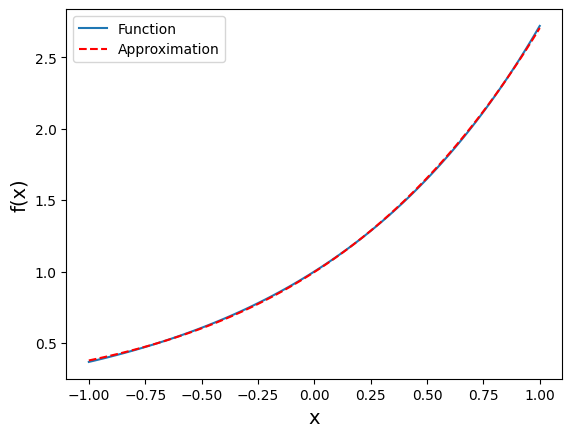

In [15]:
k = 1

plt.plot(k*x_eval, torch.exp(k*x_eval).detach().numpy(),label = 'Function')
plt.plot(k*x_eval, neural_net(k*x_eval).detach().numpy(), 'r--', label = 'Approximation') # passed input through neural network training
plt.xlabel('x', fontsize = 14)
plt.ylabel('f(x)', fontsize = 14)
plt.legend()

In [17]:
print_basis_function_sum(neural_net)

Neural Network Output Function:
f(x) = +51.1452 * exp(-0.5 * ((x - 6.9405) / 2.4289)^2) +0.1338


Gaussian

In [5]:
def gaussian(x, mu, sigma):
    return torch.exp(-0.5 * ((x - mu) / sigma)**2) # mu: mean, sigma: standard deviation

In [10]:
neural_net = SimpleFNN(num_gaussians=1,num_sigmoids=0,output_size=1)

x_eval = torch.linspace(-1, 1, 100).unsqueeze(1) # shape (100, 1)  [unsqueeze to add feature dimension]
optimizer = optim.Adam(neural_net.parameters(), lr=1e-3) # Adam optimizer at learning rate 0.001
criterion = nn.MSELoss() # Mean Squared Error loss  [how far your model’s predictions are from the target values]

previous_loss = 100
for epoch in range(1000000):
    optimizer.zero_grad() # zero the parameter gradients
    y_pred = neural_net(x_eval)
    y_true = gaussian(x_eval, 0, 1) # target function: y = e^[-0.5 * ((x- mean)/ std dev)^2]  {gaussian}
    l1_norm = torch.norm(neural_net.fc2.weight, 1) # computes the sum of absolute values of all weights in fc2
    loss = criterion(y_pred, y_true)# + torch.tensor(0.002)*l1_norm
    loss.backward() # backpropagation  [looks at how the loss changes nd calculates how each weight contributed to that loss]
    optimizer.step() # update weights based on gradients calculated during backpropagation

    if epoch % 10000 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.6f}")
        print("Amplitudes:", neural_net.fc2.weight)
        current_loss = loss
        previous_loss = loss

Epoch 0, Loss 0.624143
Amplitudes: Parameter containing:
tensor([[1.0010]], requires_grad=True)
Epoch 10000, Loss 0.000004
Amplitudes: Parameter containing:
tensor([[1.2834]], requires_grad=True)
Epoch 20000, Loss 0.000000
Amplitudes: Parameter containing:
tensor([[1.0106]], requires_grad=True)
Epoch 30000, Loss 0.000000
Amplitudes: Parameter containing:
tensor([[1.0000]], requires_grad=True)
Epoch 40000, Loss 0.000000
Amplitudes: Parameter containing:
tensor([[1.0000]], requires_grad=True)
Epoch 50000, Loss 0.000000
Amplitudes: Parameter containing:
tensor([[1.0000]], requires_grad=True)
Epoch 60000, Loss 0.000000
Amplitudes: Parameter containing:
tensor([[1.0000]], requires_grad=True)
Epoch 70000, Loss 0.000000
Amplitudes: Parameter containing:
tensor([[1.0000]], requires_grad=True)
Epoch 80000, Loss 0.000000
Amplitudes: Parameter containing:
tensor([[1.0000]], requires_grad=True)
Epoch 90000, Loss 0.000000
Amplitudes: Parameter containing:
tensor([[1.0000]], requires_grad=True)
Epoc

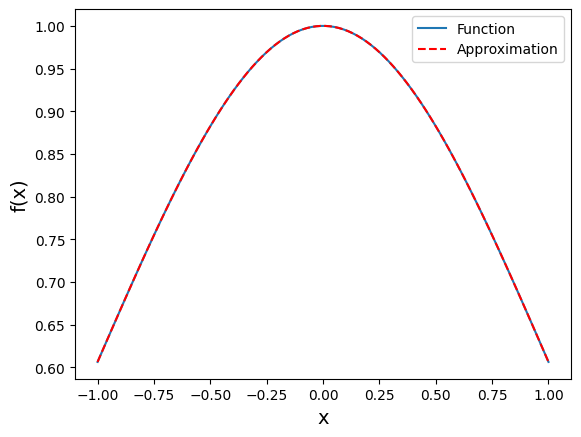

In [11]:
k = 1

plt.plot(k*x_eval, gaussian(k*x_eval, 0, 1).detach().numpy(),label = 'Function')
plt.plot(k*x_eval, neural_net(k*x_eval).detach().numpy(), 'r--', label = 'Approximation') # passed input through neural network training
plt.xlabel('x', fontsize = 14)
plt.ylabel('f(x)', fontsize = 14)
plt.legend()

In [12]:
print_basis_function_sum(neural_net)

Neural Network Output Function:
f(x) = +1.0000 * exp(-0.5 * ((x - 0.0000) / 1.0000)^2) +0.0000
